In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Clustering
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2025-03-07 10:57:37.909691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 10:57:37.926205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 10:57:37.931423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1741341459.269820 1172960 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741341459.308539 1172960 cuda_executor.cc:1015] succ

## learnMSA tree demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
name = "8_200"

# unaligned sequences
train_filename = f"../trees/alisim/{name}.unaligned.fa"
# reference alignment of all sequences
ref_filename = f"../trees/alisim/{name}.phy"
# tree used to generate the sequences
tree_filename = f"../trees/treegen/trees/{name}.nwk"

# number of distinct pHMMs
num_models = 2

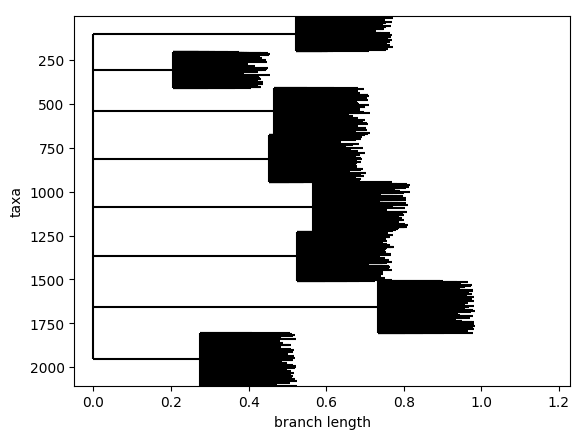

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

## Run learnMSA from Python (Training + Viterbi alignment)

In [4]:
# compute a clustering from the unaligned sequences
clustering : pd.DataFrame = Clustering.compute_clustering(train_filename, cluster_seq_id=0.3, linear=False)
tree_handler = Clustering.cluster_tree(clustering)

# fig = plt.figure(figsize=(10, 50), dpi=100)
# axes = fig.add_subplot(1, 1, 1)
# print("Number of clusters:", tree_handler.num_anc-1)
# tree_handler.draw(no_labels=True, axes=axes)

Falsely clustered sequences can lead to poor alignments. We'll have to account for that.

In [5]:
# compute cluster sensitivity
true_cluster_indices = true_tree.get_parent_indices_by_height(0)
cluster_indices = tree_handler.get_parent_indices_by_height(0)

true_positives = 0
positives = 0   

leaf_names = tree_handler.node_names[:tree_handler.num_leaves]
for i,u_name in enumerate(leaf_names):
    for v_name in leaf_names[i+1:]:
        u = tree_handler.nodes[u_name]
        v = tree_handler.nodes[v_name]
        tu = true_tree.nodes[u_name]
        tv = true_tree.nodes[v_name]
        if u.parent == v.parent:
            if tu.parent == tv.parent:
                true_positives += 1
            positives += 1

print("Cluster sensitivity:", true_positives/positives)
print("True number of clusters: ", true_tree.num_anc-1)
print("Predicted number of clusters: ", tree_handler.num_anc-1)

Cluster sensitivity: 0.8170548991617953
True number of clusters:  8
Predicted number of clusters:  7


In [6]:
out_filename = "test/data/interactive.alignment.fasta"
with SequenceDataset(train_filename, fmt="fasta") as data:
    tree_handler = Clustering.star_tree(data.seq_ids)
    config = Configuration.make_default(num_models, tree_handler=tree_handler)
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        verbose=True,
                                        align_insertions=True)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

Training of 2 models on file 8_200.unaligned.fa
Configuration: 
{
num_models : 2
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_sin

KeyboardInterrupt: 

In [ ]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

In [ ]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp